# 835 Final Project

In [12]:
!wget https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py

--2024-12-05 12:57:33--  https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4137 (4.0K) [text/plain]
Saving to: ‘losses.py.1’

losses.py.1         100%[===================>]   4.04K  --.-KB/s    in 0s      

2024-12-05 12:57:34 (28.6 MB/s) - ‘losses.py.1’ saved [4137/4137]



In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchvision.models import mobilenet_v2, mobilenet_v3_large, vgg19, vgg16, resnet50, resnet18
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from losses import SupConLoss
from torch.nn import TripletMarginLoss
import random
from Utils import CustomDataset, GaussianNoise, ImageMask, RandomRotationTensor, MultiView, RandomFlip, RandomCut

### Create dataset

In [3]:
# Load Kaggle dataset
path = kagglehub.dataset_download("juanda220485/synthetic-dataset-of-speckle-images")
print("Path to dataset files:", path)


# add randomized rotation
dataset = CustomDataset(path, transform=torchvision.transforms.Compose([
    MultiView(torchvision.transforms.Compose([
        lambda x : x.unsqueeze(0),
        GaussianNoise(mean=0.0, sigma=(1, 15), clamp=255),
        lambda x : x / 255.0,
        ImageMask(sz=(126, 126)),
        RandomRotationTensor(degrees=360, samples=128),
        RandomFlip(prob=0.667),
        RandomCut((64, 64))
    ]), n_views=10)
])
)

Path to dataset files: /Users/petertso/.cache/kagglehub/datasets/juanda220485/synthetic-dataset-of-speckle-images/versions/1


### View 10 images in dataset

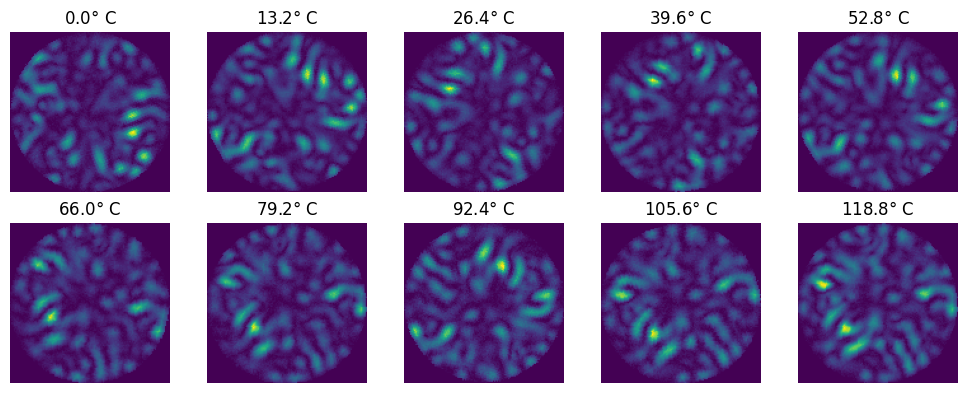

In [17]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    image_tensor, temperature = dataset[66*i]
    image_np = image_tensor.numpy().squeeze()
    img=plt.imshow(image_np)
    plt.title(f"{temperature.item():.1f}$\degree$ C")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Visualize spatial FFT

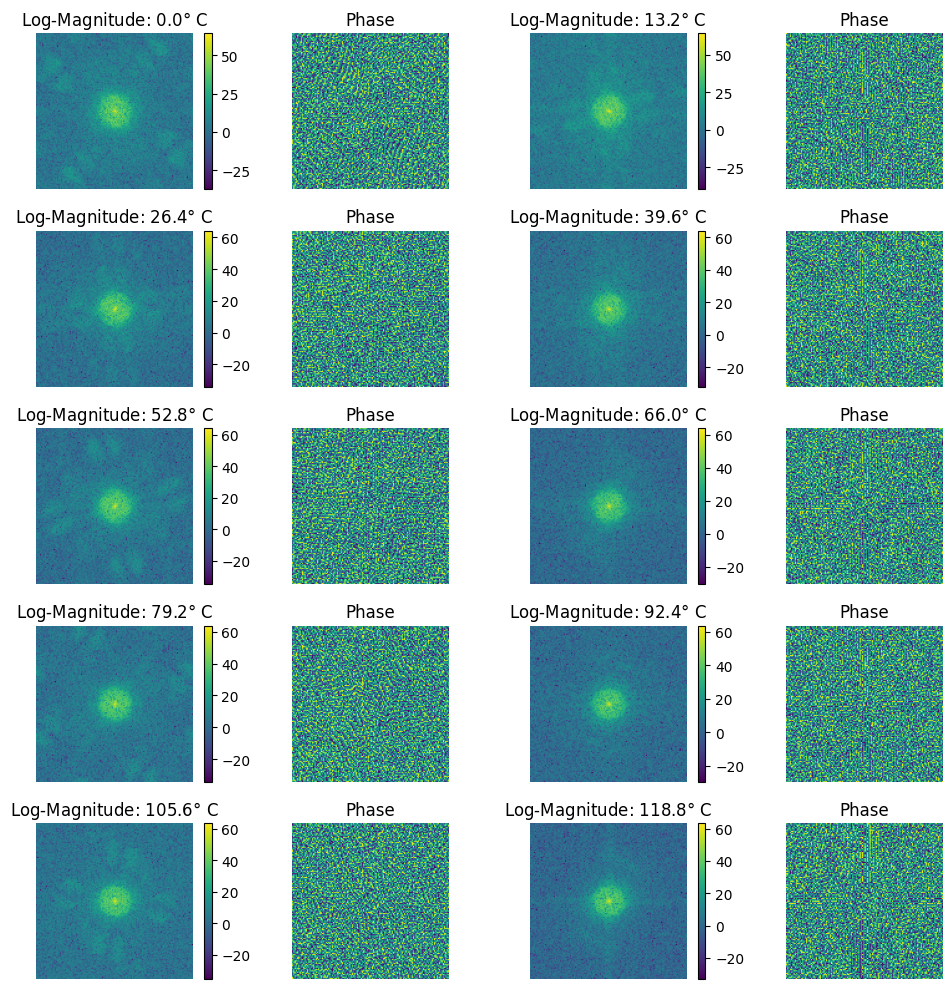

In [18]:
plt.figure(figsize=(10,10))
for i in range(0,10*2,2):
    plt.subplot(5, 4, 1 + i)
    image_tensor, temperature = dataset[66*(i//2)]
    image_np = image_tensor.numpy().squeeze()
    ff = np.fft.fftshift(np.fft.fft2(image_np))

    m = 10*np.log10(np.abs(ff)**2)
    img=plt.imshow(m)
    plt.title(f"Log-Magnitude: {temperature.item():.1f}$\degree$ C")
    plt.axis('off')
    plt.colorbar()

    plt.subplot(5, 4, 1 + i + 1)
    a = np.angle(ff) + 3.1415   # shift from (-pi, pi) to (0, 2pi)
    img=plt.imshow(a)
    plt.title(f"Phase")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Plot correlation w.r.t to 0.0 °C

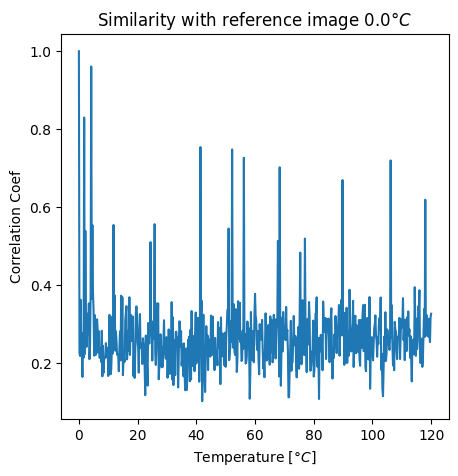

In [19]:
X, y = dataset.numpy(raw=False)
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X = X - X.mean(axis=1, keepdims=True)
correlations = np.array([np.corrcoef(X[0,:], X[i,:])[0, 1] for i in range(X.shape[0])])

plt.figure(figsize=[5,5])
plt.plot(y, correlations)
plt.title("Similarity with reference image $0.0\degree C$")
plt.xlabel("Temperature $[\degree C]$")
plt.ylabel("Correlation Coef")
plt.show()

### Model
Model architecture based on TractoSCR

In [ ]:
class SupConModel(nn.Module):
  def __init__(self, feature_dim : int = 128, device : str = "cpu")->None:
    super(SupConModel, self).__init__()
    self.backbone = resnet18(pretrained=True)
    self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.backbone.fc    = nn.Identity()
    self.linear = nn.Linear(512, 512)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)

    self.projector = nn.Sequential(
      nn.ReLU(inplace=True),
      nn.Linear(512, feature_dim),
    ).to(device)

  def forward(self, X):
    X = self.encoder(X)
    X = F.normalize(self.projector(X), dim=1)

    return X

class PairDet:
  def __init__(self, threshold : float = 1.0):
    self.T = threshold

  def __call__(self, y : torch.Tensor)->torch.Tensor:
    # A positive pair is when |yi - yj| <= T, were i, j in N
    # This returns a square matrix of (N, N) where
    # each row is an image, and each column where Aij = 1 is a positive pair
    #

    # replicate y, such that [y, y, ..., y] for N columns
    N  = len(y)
    Y  = y.expand(-1, N)
    Q  = torch.abs(Y - Y.T) <= self.T

    return Q


### Model training

In [ ]:
# Hyperparameters
batch_size  = 128
epochs      = 150
lr          = 1e-4
split_ratio = 0.9   # %
device      = "cuda:0"
views       = 5
features_dim = 64

sz = (126, 126)
dataset = CustomDataset(path, transform=torchvision.transforms.Compose([
    MultiView(torchvision.transforms.Compose([
        lambda x : x.unsqueeze(0),
        GaussianNoise(mean=0.0, sigma=(1, 15), clamp=255),
        lambda x : x / 255.0,
        ImageMask(sz=(126, 126)),
        RandomRotationTensor(degrees=360, samples=128),   # Basic Augmentations

        RandomFlip(prob=0.667), # Additional Augmentations
        RandomCut((96, 96)),
    ]), n_views=4)
])
)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

supconmodel = SupConModel(features_dim, device).to(device)
optimizer   = torch.optim.Adam(supconmodel.parameters(), lr=lr,)
pdr         = PairDet(threshold = 1)
lossfn      = SupConLoss(base_temperature=0.001, temperature=0.01)

for epoch in range(epochs):
  supconmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')

  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.to(device).unsqueeze(1) #.expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pairs = pdr(temperatures).to(device)
    proj  = supconmodel(images).reshape(N, V, features_dim)
    loss  = lossfn(proj, mask=pairs)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1
    print(f'*', end='')
  print('\n')
  print(f'Loss: {losses / count}')

### Fine-tuning

In [8]:
class RegressionModel(torch.nn.Module):
  def __init__(self, supconmodel : SupConModel, device : str = 'cpu')->None:
    super(RegressionModel, self).__init__()
    self.encoder = supconmodel.encoder

    for param in self.encoder.parameters():
      param.requires_grad = False

    self.head = nn.Sequential (
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 1),
    ).to(device)

  def forward(self, X):
    with torch.no_grad():
      X = self.encoder(X)
    X = self.head(X)

    return X

In [9]:
batch_size  = 64
epochs      = 200
lr          = 1e-3
split_ratio = 0.9   # %
device      = "cuda:0"
views       = 5
features_dim = 64

dataset = CustomDataset(path, transform=torchvision.transforms.Compose([
    MultiView(torchvision.transforms.Compose([
        lambda x : x.unsqueeze(0),
        GaussianNoise(mean=0.0, sigma=(1, 15), clamp=255),
        lambda x : x / 255.0,
        ImageMask(sz=(126, 126)),
        RandomRotationTensor(degrees=360, samples=128),
    ]), n_views=1)
])
)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

regmodel = RegressionModel(supconmodel, device)
optimizer   = torch.optim.Adam(regmodel.parameters(), lr=lr, weight_decay=1e-4)
lossfn      = torch.nn.MSELoss()

for epoch in range(epochs):
  regmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')
  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N = images.shape[0]
    V = images.shape[1]
    images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.to(device).unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pred  = regmodel(images)
    loss  = lossfn(pred, temperatures)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1

    print(f'*', end='')
  print('\n')
  print(f'MSE : {losses / count}')
  print(f'RMSE: {np.sqrt(losses / count)}')

  with torch.no_grad():
    losses = 0
    count  = 0
    y_pred = []
    y_test = []
    for images, temperatures in val_loader:
      N = images.shape[0]
      V = images.shape[1]
      images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
      temperatures = temperatures.to(device).unsqueeze(1).expand(-1, V).reshape(N * V, 1)
      pred = regmodel(images)
      loss = lossfn(pred, temperatures)
      losses += loss.cpu().detach().numpy()
      count += 1

      y_pred.append(pred.squeeze().cpu().detach().numpy())
      y_test.append(temperatures.squeeze().cpu().detach().numpy())
      
  y_pred = np.array(y_pred).flatten()
  y_test = np.array(y_test).flatten()

  print(f'Validation: MSE : {losses / count}')
  print(f'Validation: RMSE: {np.sqrt(losses / count)}')
  print(f'Validation R2: {r2_score(y_test, y_pred)}')

########################################
Epoch: 1
**********************************

MSE : 4815.467737534467
RMSE: 69.393571298316
Validation: MSE : 4170.6815185546875
Validation: RMSE: 64.58081385794614
########################################
Epoch: 2
**********************************

MSE : 4544.582095875459
RMSE: 67.4135156765723
Validation: MSE : 3777.80859375
Validation: RMSE: 61.463880399385786
########################################
Epoch: 3
**********************************

MSE : 3945.719392664292
RMSE: 62.81496153516527
Validation: MSE : 3020.6455688476562
Validation: RMSE: 54.960400006255924
########################################
Epoch: 4
**********************************

MSE : 3026.4569307215074
RMSE: 55.01324323034871
Validation: MSE : 2121.6932983398438
Validation: RMSE: 46.0618421075389
########################################
Epoch: 5
**********************************

MSE : 2037.2761840820312
RMSE: 45.13619594163902
Validation: MSE : 1248.5873413085938
Valida

### Compare to Linear Regression

The dataset https://pmc.ncbi.nlm.nih.gov/articles/PMC10139894/ approximates change in refractive index $n$ as:

$
  n \approx n_0 + C_{TO}\Delta T
$

$
  \nabla \times \nabla \times \vec{E} - k_0^{2}n^{2}\vec{E} = 0
$

#######################################
Actual temperatures:		[ 22.   83.8 113.   15.4  36.2]
Predicted temperatures:		[ 24.684082  88.03763  107.26764   20.315582  42.0885  ]
R2: 0.983123779296875
MSE: 22.448379516601562, RMSE: 4.737972259521484
MAE: 3.757389545440674


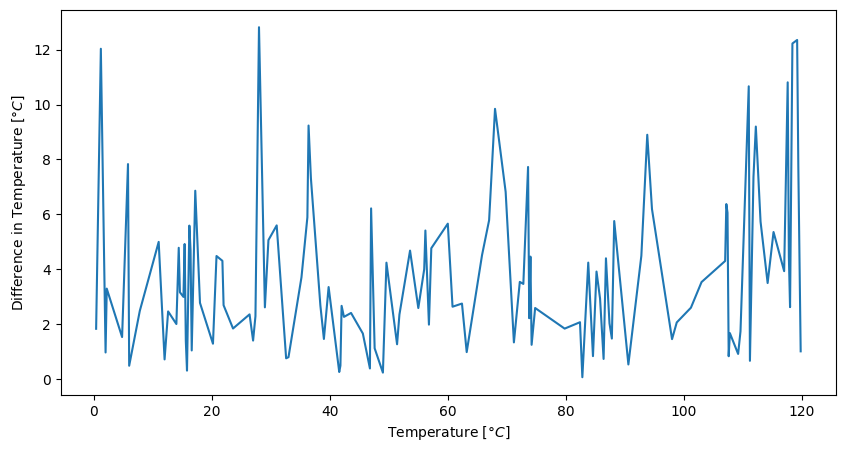

In [ ]:
from sklearn.model_selection import train_test_split

X, y = dataset.numpy(raw=False)
N = X.shape[0]
V = X.shape[1]
X = torch.tensor(X).reshape(N * V, 1, sz[0], sz[1]).reshape(N * V, sz[0] * sz[1]).cpu().detach().numpy()
y = torch.tensor(y).unsqueeze(1).expand(-1, V).reshape(N * V, 1).squeeze(-1).cpu().detach().numpy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

lr_rg = LinearRegression()
lr_rg.fit(X_train, y_train)

y_pred = lr_rg.predict(X_test)


# print r2 score and predictions
print("#######################################")
print(f"Actual temperatures:\t\t{y_test[:5]}")
print(f"Predicted temperatures:\t\t{y_pred[:5]}")
print(f"R2: {r2_score(y_test, y_pred)}")
print(f"MSE: {np.mean((y_test - y_pred) ** 2)}, RMSE: {np.sqrt(np.mean((y_test - y_pred) ** 2))}")
print(f"MAE: {np.mean(np.abs(y_test - y_pred))}")

# print out differences per temperature
# Get the sorting indices from the first vector
idxs = np.argsort(y_test)

# Sort both vectors using the sorting indices
xx = y_test[idxs]
yy = np.abs(y_test - y_pred)[idxs]


plt.figure(figsize=[10, 5])
plt.plot(xx, yy)
plt.xlabel(f"Temperature [$\degree C$]")
plt.ylabel(f"Difference in Temperature [$\degree C$]")
plt.show()